## Инициализация

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# to make torch.use_deterministic_algorithms(True) work
os.environ.update({'CUBLAS_WORKSPACE_CONFIG': ':4096:8'})

In [3]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio


seed = 3407
_ = torch.manual_seed(seed)
rng = np.random.default_rng(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)

In [4]:
from src.augmentations import DefaultWave2Spec
from src.configs import DefaultConfig
from src.data_utils import SpeechCommandsDataset
from src.models import StreamingCRNN

In [5]:
CHECKPOINT_DIR = Path('checkpoints/baseline.pth')
DATA_DIR = Path('data/speech_commands')

In [6]:
config = DefaultConfig(device=torch.device('cpu'))
crnn_state_dict = torch.load(CHECKPOINT_DIR, map_location=config.device)
scrnn = StreamingCRNN(window_length=20, config=config)
scrnn.load_crnn_state_dict(crnn_state_dict)
scrnn = scrnn.eval()

## Эксперимент
Давайте проведем эксперимент следующим образом: возьмем 10 аудиозаписей без ключевого слова и поместим в середину аудио с ключевым словом, склеим все это в одно аудио.
Потом подадим все это на вход модели и посмотрим на вероятности, которые она нам выдаст.

In [7]:
ds = SpeechCommandsDataset(path2dir=DATA_DIR, keywords=config.keyword)

In [8]:
no_kw = ds.csv[ds.csv.label == 0].path.sample(10, random_state=seed).values.tolist()
no_kw

['no/37a3cd33_nohash_0.wav',
 'four/2579e514_nohash_0.wav',
 'zero/435f9f9e_nohash_1.wav',
 'three/5a9f7324_nohash_0.wav',
 'off/b49caed3_nohash_0.wav',
 'house/b1de039c_nohash_2.wav',
 'dog/6f7724f5_nohash_3.wav',
 'off/3d53244b_nohash_2.wav',
 'left/4ec7d027_nohash_2.wav',
 'dog/28497c5b_nohash_1.wav']

In [9]:
has_kw = ds.csv[ds.csv.label == 1].path.sample(1, random_state=seed).iloc[0]
has_kw

'sheila/e3b64217_nohash_0.wav'

In [10]:
wav = torch.cat([
    torchaudio.load(DATA_DIR / path)[0].squeeze() for path in
    (*no_kw[:5], has_kw, *no_kw[5:])
])

In [11]:
wav.shape

torch.Size([175019])

In [12]:
wave2spec = DefaultWave2Spec(is_train=False, config=config)
spec = wave2spec(wav[None, :]).squeeze().T
spec.shape

torch.Size([1094, 40])

In [13]:
probs = []
scrnn.reset_streaming()
for frame in spec:
    probs.append(scrnn.process_frame(frame)[1].item())

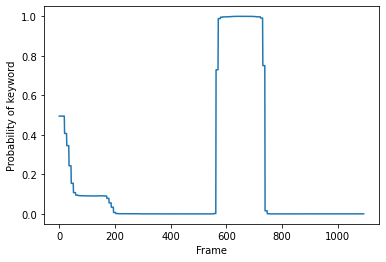

In [14]:
_ = plt.plot(probs)
_ = plt.xlabel('Frame')
_ = plt.ylabel('Probability of keyword')

Как мы видим, вероятности согласуются со здравым смыслом. Сначала они равны примерно 0.5, потому что на этом этапе очень мало информации, и модель не уверена в своем предсказании.
Примерно в середине мы видим резкий скачок, а потом вероятности снова затухают, потому что модель начинает забывать, что было ранее.